In [1]:
!pip install -q kaggle timm h5py torchmetrics tqdm seaborn matplotlib scikit-learn torchinfo


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 21.2 MB/s eta 0:00:00


In [2]:
import os, json, h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassAUROC,
    MulticlassMatthewsCorrCoef
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [3]:
KAGGLE_USERNAME = "YOUR_USERNAME"
KAGGLE_KEY = "YOUR_KEY"

os.makedirs("/root/.config/kaggle", exist_ok=True)
with open("/root/.config/kaggle/kaggle.json", "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
os.chmod("/root/.config/kaggle/kaggle.json", 0o600)

from kaggle.api.kaggle_api_extended import KaggleApi

DATA_DIR = "brain_tumor_dataset"
DATASET = "ashkhagan/figshare-brain-tumor-dataset"

if not os.path.exists(DATA_DIR):
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(DATASET, path=DATA_DIR, unzip=True)


Dataset URL: https://www.kaggle.com/datasets/ashkhagan/figshare-brain-tumor-dataset


In [4]:
mat_files = []
for root, _, files in os.walk(DATA_DIR):
    for f in files:
        if f.endswith(".mat") and "cvind" not in f.lower():
            mat_files.append(os.path.join(root, f))

paths, labels = [], []

for f in mat_files:
    with h5py.File(f, "r") as mat:
        if "label" in mat:
            label = int(mat["label"][()][0][0])
        else:
            label = int(mat["cjdata"]["label"][()][0][0])
    paths.append(f)
    labels.append(label - 1)

df = pd.DataFrame({"image_path": paths, "label": labels})
num_classes = df["label"].nunique()

train_df, test_df = train_test_split(df, stratify=df.label, test_size=0.2, random_state=42)
train_df, val_df  = train_test_split(train_df, stratify=train_df.label, test_size=0.2, random_state=42)


In [5]:
class BrainTumorDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "image_path"]
        label = self.df.loc[idx, "label"]

        with h5py.File(path, "r") as mat:
            if "image" in mat:
                img = mat["image"][()]
            else:
                img = mat["cjdata"]["image"][()]

        img = np.array(img).T
        img = np.stack([img]*3, axis=-1).astype(np.uint8)
        img = self.transform(img)

        return img, label


In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),
                         (0.229,0.224,0.225))
])

train_loader = DataLoader(BrainTumorDataset(train_df, transform), batch_size=8, shuffle=True)
val_loader   = DataLoader(BrainTumorDataset(val_df, transform), batch_size=8)
test_loader  = DataLoader(BrainTumorDataset(test_df, transform), batch_size=8)


In [7]:
model = timm.create_model(
    "densenet121",
    pretrained=True,
    num_classes=num_classes
)

model = model.to(device)


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

EPOCHS = 30
patience = 5

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=EPOCHS
)


In [9]:
def get_metrics():
    return {
        "acc": MulticlassAccuracy(num_classes=num_classes).to(device),
        "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
        "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
        "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
        "auc": MulticlassAUROC(num_classes=num_classes).to(device),
        "mcc": MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
    }

def multiclass_specificity_sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    spec, sens = [], []

    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        tn = cm.sum() - (tp+fp+fn)

        spec.append(tn/(tn+fp+1e-8))
        sens.append(tp/(tp+fn+1e-8))

    return float(np.mean(spec)), float(np.mean(sens))


In [10]:
history = {
    "loss": [], "val_loss": [],
    "accuracy": [], "val_accuracy": [],
    "precision": [], "val_precision": [],
    "recall": [], "val_recall": [],
    "f1": [], "val_f1": [],
    "specificity": [], "val_specificity": [],
    "sensitivity": [], "val_sensitivity": [],
    "mcc": [], "val_mcc": [],
    "auc": [], "val_auc": []
}

best_val_loss = float("inf")
counter = 0

for epoch in range(EPOCHS):

    # ================= TRAIN =================
    model.train()
    train_loss = 0
    train_preds, train_targets = [], []
    train_metrics = get_metrics()

    pbar = tqdm(train_loader,
                desc=f"Training Model - Epoch [{epoch+1}/{EPOCHS}]")

    for x,y in pbar:
        x,y = x.to(device), y.to(device)

        optimizer.zero_grad()

        outputs = model(x)

        # Handle tuple (Inception safety)
        if isinstance(outputs, tuple):
            main_out, aux_out = outputs
            loss = criterion(main_out, y) + 0.4 * criterion(aux_out, y)
            out = main_out
        else:
            loss = criterion(outputs, y)
            out = outputs

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = out.argmax(1)
        train_preds.append(preds.cpu())
        train_targets.append(y.cpu())

        for m in train_metrics.values():
            m.update(out, y)

    train_loss /= len(train_loader)

    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()

    train_spec, train_sens = multiclass_specificity_sensitivity(
        train_targets, train_preds
    )

    train_out = {k:v.compute().item() for k,v in train_metrics.items()}

    print(f"\n[TRAIN] loss: {train_loss:.4f}, "
          f"accuracy: {train_out['acc']:.4f}, "
          f"precision: {train_out['precision']:.4f}, "
          f"recall: {train_out['recall']:.4f}, "
          f"f1_score: {train_out['f1']:.4f}, "
          f"specificity: {train_spec:.4f}, "
          f"sensitivity: {train_sens:.4f}, "
          f"mcc: {train_out['mcc']:.4f}, "
          f"auc: {train_out['auc']:.4f}")

    # ===== STORE TRAIN HISTORY =====
    history["loss"].append(train_loss)
    history["accuracy"].append(train_out["acc"])
    history["precision"].append(train_out["precision"])
    history["recall"].append(train_out["recall"])
    history["f1"].append(train_out["f1"])
    history["specificity"].append(train_spec)
    history["sensitivity"].append(train_sens)
    history["mcc"].append(train_out["mcc"])
    history["auc"].append(train_out["auc"])

    for m in train_metrics.values():
        m.reset()

    # ================= VALID =================
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []
    val_metrics = get_metrics()

    pbar = tqdm(val_loader, desc="Validating Model")

    with torch.no_grad():
        for x,y in pbar:
            x,y = x.to(device), y.to(device)

            outputs = model(x)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, y)
            val_loss += loss.item()

            preds = outputs.argmax(1)
            val_preds.append(preds.cpu())
            val_targets.append(y.cpu())

            for m in val_metrics.values():
                m.update(outputs, y)

    val_loss /= len(val_loader)

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()

    val_spec, val_sens = multiclass_specificity_sensitivity(
        val_targets, val_preds
    )

    val_out = {k:v.compute().item() for k,v in val_metrics.items()}

    print(f"[VAL]   loss: {val_loss:.4f}, "
          f"accuracy: {val_out['acc']:.4f}, "
          f"precision: {val_out['precision']:.4f}, "
          f"recall: {val_out['recall']:.4f}, "
          f"f1_score: {val_out['f1']:.4f}, "
          f"specificity: {val_spec:.4f}, "
          f"sensitivity: {val_sens:.4f}, "
          f"mcc: {val_out['mcc']:.4f}, "
          f"auc: {val_out['auc']:.4f}")

    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6e}\n")

    # ===== STORE VAL HISTORY =====
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_out["acc"])
    history["val_precision"].append(val_out["precision"])
    history["val_recall"].append(val_out["recall"])
    history["val_f1"].append(val_out["f1"])
    history["val_specificity"].append(val_spec)
    history["val_sensitivity"].append(val_sens)
    history["val_mcc"].append(val_out["mcc"])
    history["val_auc"].append(val_out["auc"])

    scheduler.step()

    for m in val_metrics.values():
        m.reset()

    # ===== EARLY STOPPING =====
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Training Model - Epoch [1/30]: 100%|██████████| 245/245 [00:49<00:00,  4.99it/s]



[TRAIN] loss: 0.5053, accuracy: 0.7805, precision: 0.7823, recall: 0.7805, f1_score: 0.7809, specificity: 0.8965, sensitivity: 0.7805, mcc: 0.6875, auc: 0.9238


Validating Model: 100%|██████████| 62/62 [00:09<00:00,  6.42it/s]


[VAL]   loss: 0.2374, accuracy: 0.9177, precision: 0.8971, recall: 0.9177, f1_score: 0.9030, specificity: 0.9601, sensitivity: 0.9177, mcc: 0.8664, auc: 0.9802
Current LR: 5.000000e-04



Training Model - Epoch [2/30]: 100%|██████████| 245/245 [00:46<00:00,  5.25it/s]



[TRAIN] loss: 0.2775, accuracy: 0.8847, precision: 0.8734, recall: 0.8847, f1_score: 0.8781, specificity: 0.9450, sensitivity: 0.8847, mcc: 0.8267, auc: 0.9718


Validating Model: 100%|██████████| 62/62 [00:08<00:00,  7.34it/s]


[VAL]   loss: 0.3378, accuracy: 0.8397, precision: 0.8530, recall: 0.8397, f1_score: 0.8370, specificity: 0.9331, sensitivity: 0.8397, mcc: 0.7933, auc: 0.9793
Current LR: 4.986305e-04



Training Model - Epoch [3/30]: 100%|██████████| 245/245 [00:48<00:00,  5.10it/s]



[TRAIN] loss: 0.2350, accuracy: 0.9018, precision: 0.8943, recall: 0.9018, f1_score: 0.8978, specificity: 0.9522, sensitivity: 0.9018, mcc: 0.8523, auc: 0.9811


Validating Model: 100%|██████████| 62/62 [00:07<00:00,  7.81it/s]


[VAL]   loss: 0.3497, accuracy: 0.8776, precision: 0.8571, recall: 0.8776, f1_score: 0.8622, specificity: 0.9420, sensitivity: 0.8776, mcc: 0.8122, auc: 0.9719
Current LR: 4.945369e-04



Training Model - Epoch [4/30]: 100%|██████████| 245/245 [00:46<00:00,  5.26it/s]



[TRAIN] loss: 0.1682, accuracy: 0.9378, precision: 0.9316, recall: 0.9378, f1_score: 0.9345, specificity: 0.9700, sensitivity: 0.9378, mcc: 0.9062, auc: 0.9903


Validating Model: 100%|██████████| 62/62 [00:08<00:00,  7.19it/s]


[VAL]   loss: 0.2906, accuracy: 0.9163, precision: 0.8948, recall: 0.9163, f1_score: 0.8965, specificity: 0.9557, sensitivity: 0.9163, mcc: 0.8556, auc: 0.9816
Current LR: 4.877641e-04



Training Model - Epoch [5/30]: 100%|██████████| 245/245 [00:46<00:00,  5.22it/s]



[TRAIN] loss: 0.1224, accuracy: 0.9514, precision: 0.9488, recall: 0.9514, f1_score: 0.9501, specificity: 0.9771, sensitivity: 0.9514, mcc: 0.9290, auc: 0.9949


Validating Model: 100%|██████████| 62/62 [00:08<00:00,  7.40it/s]


[VAL]   loss: 0.1809, accuracy: 0.9361, precision: 0.9236, recall: 0.9361, f1_score: 0.9287, specificity: 0.9691, sensitivity: 0.9361, mcc: 0.8996, auc: 0.9866
Current LR: 4.783864e-04



Training Model - Epoch [6/30]: 100%|██████████| 245/245 [00:46<00:00,  5.23it/s]



[TRAIN] loss: 0.0942, accuracy: 0.9669, precision: 0.9624, recall: 0.9669, f1_score: 0.9645, specificity: 0.9842, sensitivity: 0.9669, mcc: 0.9498, auc: 0.9967


Validating Model: 100%|██████████| 62/62 [00:08<00:00,  7.60it/s]


[VAL]   loss: 0.4661, accuracy: 0.8053, precision: 0.8977, recall: 0.8053, f1_score: 0.8162, specificity: 0.9178, sensitivity: 0.8053, mcc: 0.7924, auc: 0.9826
Current LR: 4.665064e-04



Training Model - Epoch [7/30]: 100%|██████████| 245/245 [00:47<00:00,  5.20it/s]



[TRAIN] loss: 0.0857, accuracy: 0.9644, precision: 0.9638, recall: 0.9644, f1_score: 0.9641, specificity: 0.9838, sensitivity: 0.9644, mcc: 0.9496, auc: 0.9976


Validating Model: 100%|██████████| 62/62 [00:08<00:00,  7.24it/s]


[VAL]   loss: 0.3032, accuracy: 0.8644, precision: 0.8890, recall: 0.8644, f1_score: 0.8722, specificity: 0.9411, sensitivity: 0.8644, mcc: 0.8310, auc: 0.9790
Current LR: 4.522542e-04



Training Model - Epoch [8/30]: 100%|██████████| 245/245 [00:47<00:00,  5.19it/s]



[TRAIN] loss: 0.0613, accuracy: 0.9836, precision: 0.9817, recall: 0.9836, f1_score: 0.9826, specificity: 0.9921, sensitivity: 0.9836, mcc: 0.9752, auc: 0.9982


Validating Model: 100%|██████████| 62/62 [00:07<00:00,  7.78it/s]


[VAL]   loss: 0.2650, accuracy: 0.9119, precision: 0.9084, recall: 0.9119, f1_score: 0.9092, specificity: 0.9608, sensitivity: 0.9119, mcc: 0.8767, auc: 0.9835
Current LR: 4.357862e-04



Training Model - Epoch [9/30]: 100%|██████████| 245/245 [00:47<00:00,  5.17it/s]



[TRAIN] loss: 0.0358, accuracy: 0.9873, precision: 0.9871, recall: 0.9873, f1_score: 0.9872, specificity: 0.9944, sensitivity: 0.9873, mcc: 0.9824, auc: 0.9996


Validating Model: 100%|██████████| 62/62 [00:08<00:00,  7.11it/s]


[VAL]   loss: 0.4124, accuracy: 0.8567, precision: 0.8716, recall: 0.8567, f1_score: 0.8628, specificity: 0.9288, sensitivity: 0.8567, mcc: 0.7951, auc: 0.9751
Current LR: 4.172827e-04



Training Model - Epoch [10/30]: 100%|██████████| 245/245 [00:47<00:00,  5.19it/s]



[TRAIN] loss: 0.0393, accuracy: 0.9838, precision: 0.9823, recall: 0.9838, f1_score: 0.9830, specificity: 0.9923, sensitivity: 0.9838, mcc: 0.9760, auc: 0.9994


Validating Model: 100%|██████████| 62/62 [00:08<00:00,  7.26it/s]


[VAL]   loss: 0.2405, accuracy: 0.9465, precision: 0.9295, recall: 0.9465, f1_score: 0.9362, specificity: 0.9729, sensitivity: 0.9465, mcc: 0.9101, auc: 0.9867
Current LR: 3.969463e-04

Early stopping triggered.


In [11]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNormAct2d(
      64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): DenseBlock(
      (denselayer1): DenseLayer(
        (norm1): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNormAct2d(
          128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
  

In [12]:
test_metrics = get_metrics()
test_loss = 0
all_preds, all_targets = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)
        test_loss += loss.item()

        preds = out.argmax(1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

        for m in test_metrics.values():
            m.update(out, y)

test_loss /= len(test_loader)

print("\n===== TEST RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")

for k, v in test_metrics.items():
    print(f"{k.upper()}: {v.compute().item():.4f}")


Testing: 100%|██████████| 77/77 [00:10<00:00,  7.00it/s]


===== TEST RESULTS =====
Test Loss: 0.2071
ACC: 0.9248
PRECISION: 0.9091
RECALL: 0.9248
F1: 0.9151
AUC: 0.9847
MCC: 0.8806


In [13]:
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

print("\n===== CLASSIFICATION REPORT =====\n")
print(classification_report(all_targets, all_preds, digits=4))



===== CLASSIFICATION REPORT =====

              precision    recall  f1-score   support

           0     0.7914    0.9085    0.8459       142
           1     0.9734    0.8982    0.9343       285
           2     0.9626    0.9677    0.9651       186

    accuracy                         0.9217       613
   macro avg     0.9091    0.9248    0.9151       613
weighted avg     0.9279    0.9217    0.9232       613



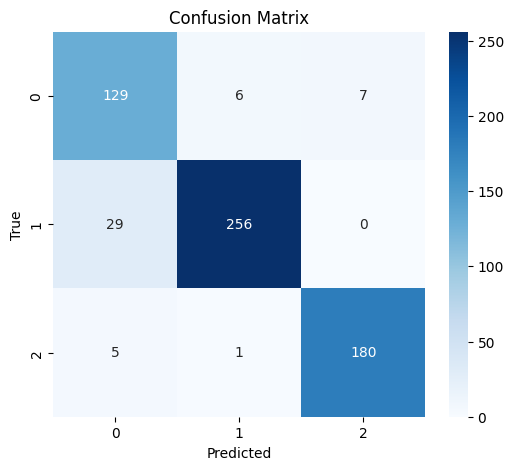

In [14]:
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [16]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


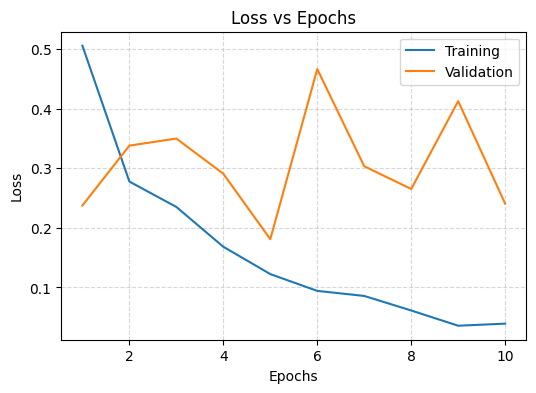

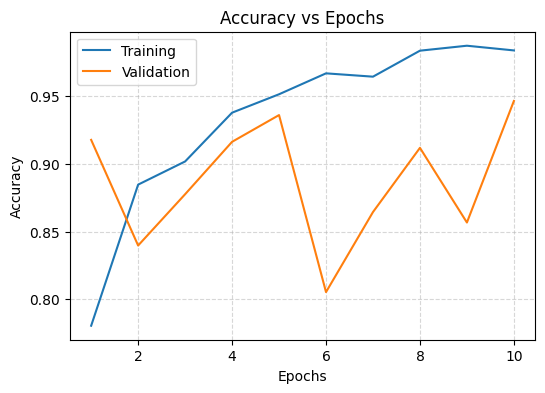

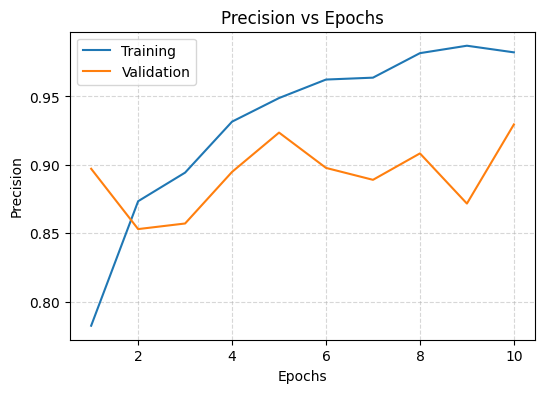

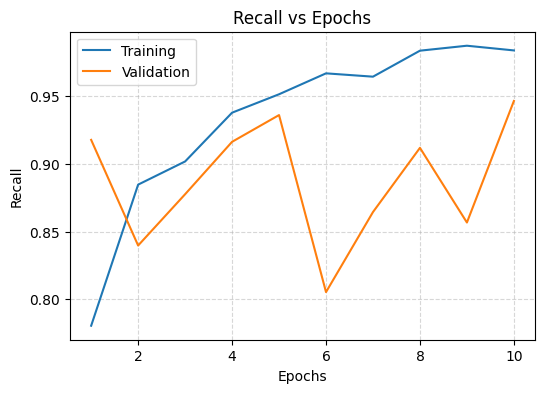

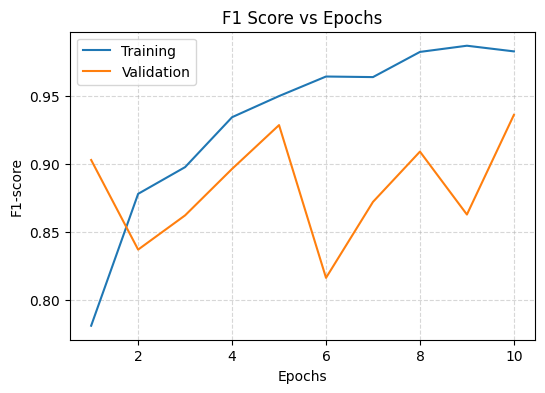

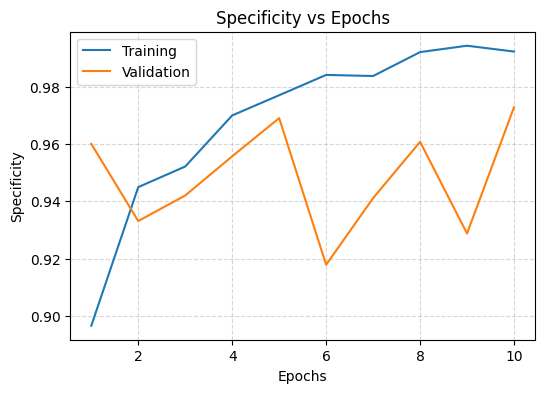

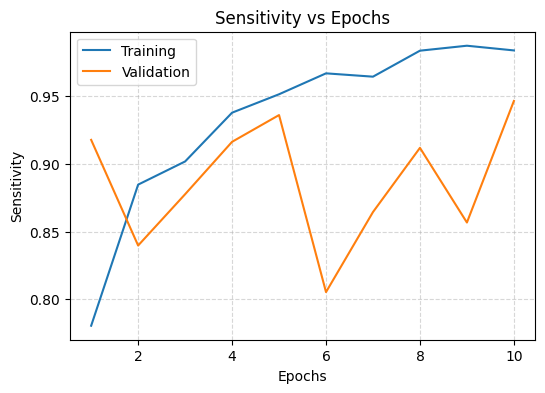

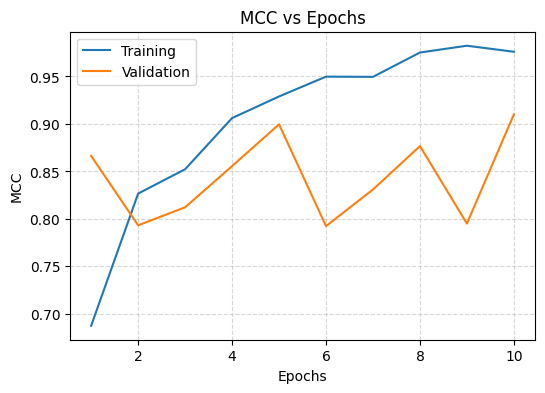

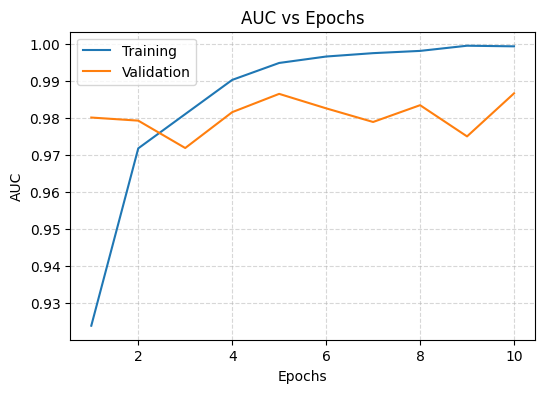

In [17]:
plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1 Score vs Epochs", "F1-score")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")
